In [ ]:
#
# REP and skip Analysis for the Flat Scan Sampling single core
# João Inácio, Mar. 31st, 2021
# 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [50]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4

L = 4
N_atm = L ** 2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1
energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

REP_vals = 10 ** np.array([2, 3, 4, 5, 6])
skip_vals = np.array([1, 4, 8, 16, 32])

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3


In [51]:
# Get the data

n_run = 1000

JDOS_all = list()
for idx_skip in range(len(skip_vals)):
    JDOS_all.append(list())
    for idx_REP in range(len(REP_vals)):
        JDOS_all[idx_skip].append(list())

cfg_chkbrd = np.zeros((n_run, len(skip_vals), len(REP_vals)))
cfg_slice = np.zeros((n_run, len(skip_vals), len(REP_vals)))
cfg_zerozero = np.zeros((n_run, len(skip_vals), len(REP_vals)))

JDOS_mean = list()
for i in range(len(skip_vals)):
    JDOS_mean.append(list())
    
wall_time_mean = list()
for i in range(len(skip_vals)):
    wall_time_mean.append(list())
    
q_time_E_mean = list()
for i in range(len(skip_vals)):
    q_time_E_mean.append(list())

for idx_skip, skip in enumerate(skip_vals):
    for idx_REP, REP in enumerate(REP_vals):
        wall_time_all = np.zeros((n_run))
        q_time_E_all = np.zeros((n_run))
        
        for run in range(1, n_run + 1):
            file_name = "".join(("./data_SS/L", str(L), "/skip/L", str(skip), "/", str(int(np.log10(REP))), 
                                 "/", str(run), "_JDOS_FSS_Ising_", dim, "_", lattice, 
                                 "_L", str(L), "_REP_1E", str(int(np.log10(REP))), 
                                 "_skip_", str(skip)))
            JDOS = np.loadtxt(file_name + ".txt")
            JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

            cfg_chkbrd[run - 1, idx_skip, idx_REP] = JDOS[len(energies) - 1, q_max+1]
            cfg_slice[run - 1, idx_skip, idx_REP] = JDOS[L, q_max+1]
            cfg_zerozero[run - 1, idx_skip, idx_REP] = JDOS[np.where(energies == 0)[0][0], q_max+1]

            JDOS_all[idx_skip][idx_REP].append(JDOS)

            with open(file_name + "_data.txt", 'r') as data_file:
                header = data_file.readline().strip("\n")

                q_time_E = np.zeros(q_max)
                for i in range(0, q_max):
                    line = data_file.readline().strip("\n").split(" ")
                    q_time_E[i] = float(line[4])

                wall_time_all[run - 1] = float(data_file.readline().strip("\n"))
                q_time_E_all[run - 1] = np.sum(q_time_E)

        JDOS_mean[idx_skip].append(sum(JDOS_all[idx_skip][idx_REP]) / n_run)
        wall_time_mean[idx_skip].append(np.mean(wall_time_all))
        q_time_E_mean[idx_skip].append(np.mean(q_time_E_all))


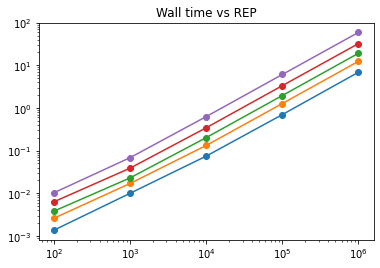

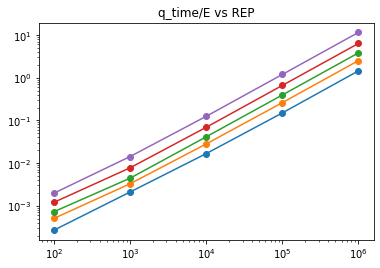

In [53]:
# Plot Wall time and q_time/E

for idx_skip in range(len(skip_vals)):

    # Wall time
    plt.figure(1)
    plt.loglog(REP_vals, wall_time_mean[idx_skip], '-o')
    plt.title("Wall time vs REP")

    # q_time/E
    plt.figure(2)
    plt.loglog(REP_vals, q_time_E_mean[idx_skip], '-o')
    plt.title("q_time/E vs REP")

plt.show()


In [54]:
fit_chkbrd = np.zeros((len(skip_vals), len(REP_vals), 2))
fit_slice = np.zeros((len(skip_vals), len(REP_vals), 2))
fit_zerozero = np.zeros((len(skip_vals), len(REP_vals), 2))

for idx_skip in range(len(skip_vals)):
    for idx_REP in range(len(REP_vals)):
    
        fit_chkbrd[idx_skip, idx_REP, :] = norm.fit(cfg_chkbrd[:, idx_skip, idx_REP])
        fit_slice[idx_skip, idx_REP, :] = norm.fit(cfg_slice[:, idx_skip, idx_REP])
        fit_zerozero[idx_skip, idx_REP, :] = norm.fit(cfg_zerozero[:, idx_skip, idx_REP])


In [56]:
if L == 4:
    JDOS_exact = np.loadtxt('JDOS_exact_L4_SS.txt')
    
    mean_error_abs = np.zeros((len(skip_vals), len(REP_vals)))
    mean_error = np.zeros((len(skip_vals), len(REP_vals)))
    var_error = np.zeros((len(skip_vals), len(REP_vals)))
    
    for idx_skip in range(len(skip_vals)):
        for idx_REP in range(len(REP_vals)):
            error_all = list()
            error_all_abs = list()
            
            for run in range(n_run):
                JDOS_error = JDOS_all[idx_skip][idx_REP][run] - JDOS_exact
                JDOS_error = JDOS_error[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
                error_all.append(np.sum(np.sum(JDOS_error)))

                JDOS_error_abs = np.abs(JDOS_all[idx_skip][idx_REP][run] - JDOS_exact)
                JDOS_error_abs = JDOS_error_abs[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
                error_all_abs.append(np.sum(np.sum(JDOS_error_abs)))

            mean_error_abs[idx_skip, idx_REP] = np.mean(error_all_abs)

            fit_error = norm.fit(error_all)
            mean_error[idx_skip, idx_REP] = fit_error[0]
            var_error[idx_skip, idx_REP] = fit_error[1]


In [62]:
for idx_skip in range(len(skip_vals)):
    with open("validation_skip_rep_" + str(skip_vals[idx_skip]) + ".txt", 'w') as file:
        for idx_REP in range(len(REP_vals)):
            file.write(f"{REP_vals[idx_REP]} {mean_error_abs[idx_skip][idx_REP]} {var_error[idx_skip][idx_REP]}\n")
            
for idx_REP in range(len(REP_vals)):
    with open("validation_rep_skip_" + str(REP_vals[idx_REP]) + ".txt", 'w') as file:
        for idx_skip in range(len(skip_vals)):
            if idx_skip == 0:
                file.write(f"{skip_vals[idx_skip]-1} {mean_error_abs[idx_skip][idx_REP]} {var_error[idx_skip][idx_REP]} {wall_time_mean[idx_skip][idx_REP]}\n")
            else:
                file.write(f"{skip_vals[idx_skip]} {mean_error_abs[idx_skip][idx_REP]} {var_error[idx_skip][idx_REP]} {wall_time_mean[idx_skip][idx_REP]}\n")
